In [1]:
from qadataset import QADataset
from config import dataset_config, model_config

MODEL_ID = "Salesforce/blip2-opt-2.7b"


train_dataset = QADataset(dataset_config, split="train[:6]")
val_dataset = train_dataset

/home/atomwalk12/Dropbox (Old)/notes/vision/project/BeyondVisionQA/model.py:128: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  self.metric = load_metric("bertscore")
/home/atomwalk12/anaconda3/envs/questllama/lib/python3.9/site-packages/datasets/load.py:756: FutureWarning: The repository for bertscore contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/bertscore/bertscore.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Map:   0%|          | 0/38575 [00:00<?, ? examples/s]

In [3]:
from transformers import BitsAndBytesConfig, Blip2ForConditionalGeneration
import torch

## Load model

# Three options for training, from the lowest precision training to the highest precision training:
# - QLora
# - Standard Lora
# - Full fine-tuning

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16
)
model = Blip2ForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16,
    quantization_config=bnb_config,
)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
from torch.utils.data import Dataset, DataLoader
from trainer_blip2 import BLIP2ModelPLModule
from trainer_blip2 import BLIP2PLModule
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoProcessor, Blip2ForConditionalGeneration
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules="all-linear",
    init_lora_weights="gaussian",
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

In [5]:
import lightning as L
import torch
from config import dataset_config
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader
from config import metrics
from transformers import AutoProcessor
from dataset_configs.easy_vqa import translate
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right" # during training, one always uses padding on the right

class BLIP2ModelPLModule(L.LightningModule):
    def __init__(self, hyperparameters, model, train_dataset, val_dataset):
        super().__init__()
        self.hyperparams = hyperparameters
        self.model = model
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

        self.batch_size = hyperparameters.get("batch_size")

    def training_step(self, batch, batch_idx):

        inputs, labels = batch

        outputs = self.model(**inputs,
                            labels=labels)
        loss = outputs.loss
        print(f"Epoch {self.current_epoch}, loss: {loss.item()}")

        self.log("train_loss", loss, batch_size=self.batch_size)

        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):

        inputs, answers = batch

        # auto-regressively generate token IDs

        
        generated_ids = self.model.generate(**inputs)
        # turn them back into text, chopping of the prompt
        # important: we don't skip special tokens here, because we want to see them in the output
        predictions = processor.batch_decode(generated_ids, skip_special_tokens=True)

        print(f"==================Dataset batch: {batch_idx}/{self.val_dataset.dataset_length // self.batch_size}==================")
        scores = []
        i = 0
        for pred, answer in zip(predictions, answers):
            print(f"Question: {self.val_dataset.dataset[batch_idx*self.batch_size+i]['question']}")
            print(f"Prediction: {pred}")
            print(f"Answer: {answer}")
            i += 1

        for metric in metrics:
            scores = metric.compute(predictions=predictions, references=answers, model=self)
            
        return scores

    def configure_optimizers(self):
       return torch.optim.Adam(self.parameters(), lr=5e-4)
        


class BLIP2PLModule(BLIP2ModelPLModule):
    
    def __init__(self, config, model, train_dataset, val_dataset):
        super().__init__(config, model, train_dataset, val_dataset)
    
    def train_numeric_labels(examples):
        images = []
        texts = []
        batch_labels = []
        for example in examples:
            image, ground_truth = example
            input, label = translate(ground_truth, training=True)
            
            images.append(image)
            texts.append(input)
            batch_labels.append({ 'label_ids': label['label_ids'], 'scores': torch.from_numpy(label['scores'])})

        # inputs = processor(images=images, text=texts, return_tensors="pt").to(device="cuda", dtype=torch.float16)
        inputs = processor(text=texts, images=images, padding=True, truncation=True, return_tensors="pt")
        
        result = []

        for label in batch_labels:
            scores = label['scores']
            result.append(scores)
        
        return inputs, torch.stack(result)


    
    def train_textual_labels(examples):
        images = []
        texts = []
        for example in examples:
            image, ground_truth = example
            input = translate(ground_truth, training=True)
            
            images.append(image)
            texts.append(input)    

        # inputs = processor(images=images, text=texts, return_tensors="pt").to(device="cuda", dtype=torch.float16)
        inputs = processor(text=texts, images=images, padding=True, return_tensors="pt")
        
        labels = inputs["input_ids"].clone()

        return inputs, labels

    def eval_numeric_labels(examples):
        images = []
        texts = []
        answers = []
        for example in examples:
            image, ground_truth = example
            input, output = translate(ground_truth, training=False)
            
            images.append(image)
            texts.append(input) 
            answers.append(output)

        inputs = processor(text=texts, images=images, padding=True, return_tensors="pt")

        return inputs, answers
    
    def eval_textual_labels(examples):
        images = []
        texts = []
        answers = []
        for example in examples:
            image, ground_truth = example
            input, output = translate(ground_truth, training=False)
            
            images.append(image)
            texts.append(input) 
            answers.append(output)

        inputs = processor(text=texts, images=images, padding=True, return_tensors="pt")

        return inputs, answers
    
    
    def train_dataloader(self):
        if model_config['classification']:
            return DataLoader(self.train_dataset, collate_fn=BLIP2PLModule.train_numeric_labels, batch_size=self.batch_size, shuffle=True, num_workers=4)
        else:
            return DataLoader(self.train_dataset, collate_fn=BLIP2PLModule.train_textual_labels, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        if model_config['classification']:
            return DataLoader(self.val_dataset, collate_fn=BLIP2PLModule.eval_numeric_labels, batch_size=self.batch_size, shuffle=False, num_workers=4)
        else:
            return DataLoader(self.val_dataset, collate_fn=BLIP2PLModule.eval_textual_labels, batch_size=self.batch_size, shuffle=False, num_workers=4)
        
    


hyperparameters = model_config['hyperparameters']
if model_config['target'] == 'blip2':
    module = BLIP2PLModule(hyperparameters, model, train_dataset, val_dataset)

In [6]:
config = {"max_epochs": 10,
          # "val_check_interval": 0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch": 1,
          "gradient_clip_val": 1.0,
          "accumulate_grad_batches": 8,
          "lr": 1e-4,
          "batch_size": 2,
          "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 50,
          "result_path": "./result",
          "verbose": True,
}

model_module = BLIP2PLModule(config, model, train_dataset, val_dataset)

In [9]:
from lightning.pytorch.loggers import WandbLogger


trainer = L.Trainer(
        accelerator="gpu",
        devices=[0],
        max_epochs=18,
        accumulate_grad_batches=config.get("accumulate_grad_batches"),
        check_val_every_n_epoch=120,
        gradient_clip_val=config.get("gradient_clip_val"),
        precision="16-mixed",
        limit_val_batches=5,
        num_sanity_val_steps=0,
)

trainer.fit(model_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | PeftModel | 2.0 B  | train
--------------------------------------------
21.3 M    Trainable params
1.9 B     Non-trainable params
2.0 B     Total params
7,848.709 Total estimated model params size (MB)
/home/atomwalk12/anaconda3/envs/questllama/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, loss: 1.3750027418136597
Epoch 0, loss: 0.637110710144043
Epoch 0, loss: 1.4908027648925781
Epoch 1, loss: 1.6925950050354004
Epoch 1, loss: 0.6320883631706238
Epoch 1, loss: 1.5352731943130493
Epoch 2, loss: 1.4059560298919678
Epoch 2, loss: 2.0789883136749268
Epoch 2, loss: 2.6406030654907227
Epoch 3, loss: 1.2481745481491089
Epoch 3, loss: 1.6230548620224
Epoch 3, loss: 2.206968069076538
Epoch 4, loss: 1.205672025680542
Epoch 4, loss: 0.893151581287384
Epoch 4, loss: 0.8688778877258301
Epoch 5, loss: 0.4330177307128906
Epoch 5, loss: 0.6430100798606873
Epoch 5, loss: 0.5848237872123718
Epoch 6, loss: 0.596420407295227
Epoch 6, loss: 0.5761755108833313
Epoch 6, loss: 0.5866084694862366
Epoch 7, loss: 0.6213467717170715
Epoch 7, loss: 0.18414480984210968
Epoch 7, loss: 0.6228087544441223
Epoch 8, loss: 0.2063680738210678
Epoch 8, loss: 0.39960286021232605
Epoch 8, loss: 0.9112968444824219
Epoch 9, loss: 0.3898521363735199
Epoch 9, loss: 0.34126925468444824
Epoch 9, loss: 0.36

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99, loss: 0.14072725176811218


does the image not contain a gray shape?


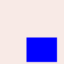

In [23]:
# load image
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
example = train_dataset[5]
image = example[0]

text_inputs = processor.tokenizer(
    example[1]["question"], padding=True, return_tensors="pt"
)
question = example[1]['question']

text = f"Question: {question} Answer:"
print(question)
image

In [24]:
inputs = processor(images=image, text=text, return_tensors="pt").to('cuda', torch.float16)
inputs

{'pixel_values': tensor([[[[1.8281, 1.8281, 1.8281,  ..., 1.8281, 1.8281, 1.8281],
          [1.8281, 1.8281, 1.8281,  ..., 1.8281, 1.8281, 1.8281],
          [1.8281, 1.8281, 1.8281,  ..., 1.8281, 1.8281, 1.8281],
          ...,
          [1.8281, 1.8281, 1.8281,  ..., 1.8281, 1.8281, 1.8281],
          [1.8281, 1.8281, 1.8281,  ..., 1.8281, 1.8281, 1.8281],
          [1.8281, 1.8281, 1.8281,  ..., 1.8281, 1.8281, 1.8281]],

         [[1.7598, 1.7598, 1.7598,  ..., 1.7598, 1.7598, 1.7598],
          [1.7598, 1.7598, 1.7598,  ..., 1.7598, 1.7598, 1.7598],
          [1.7598, 1.7598, 1.7598,  ..., 1.7598, 1.7598, 1.7598],
          ...,
          [1.7598, 1.7598, 1.7598,  ..., 1.7598, 1.7598, 1.7598],
          [1.7598, 1.7598, 1.7598,  ..., 1.7598, 1.7598, 1.7598],
          [1.7598, 1.7598, 1.7598,  ..., 1.7598, 1.7598, 1.7598]],

         [[1.7900, 1.7900, 1.7900,  ..., 1.7900, 1.7900, 1.7900],
          [1.7900, 1.7900, 1.7900,  ..., 1.7900, 1.7900, 1.7900],
          [1.7900, 1.7900

In [25]:
# prepare image for the model
import torch
inputs = processor(images=image, text=text, return_tensors="pt").to('cuda', torch.float32).to('cuda', torch.float16)
pixel_values = inputs.pixel_values

model.to('cuda')
# generated_ids = model.generate(pixel_values, max_length=25)
generated_ids = model.generate(**inputs)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

 yes.
